Episode: 1-10, Average reward: 17.11
Episode: 11-20, Average reward: 20.70
Episode: 21-30, Average reward: 22.10
Episode: 31-40, Average reward: 28.10
Episode: 41-50, Average reward: 24.00
Episode: 51-60, Average reward: 32.80
Episode: 61-70, Average reward: 39.50
Episode: 71-80, Average reward: 53.80
Episode: 81-90, Average reward: 56.20
Episode: 91-100, Average reward: 133.90
Episode: 101-110, Average reward: 150.20
Problem solved in 116 episodes! Final reward:317


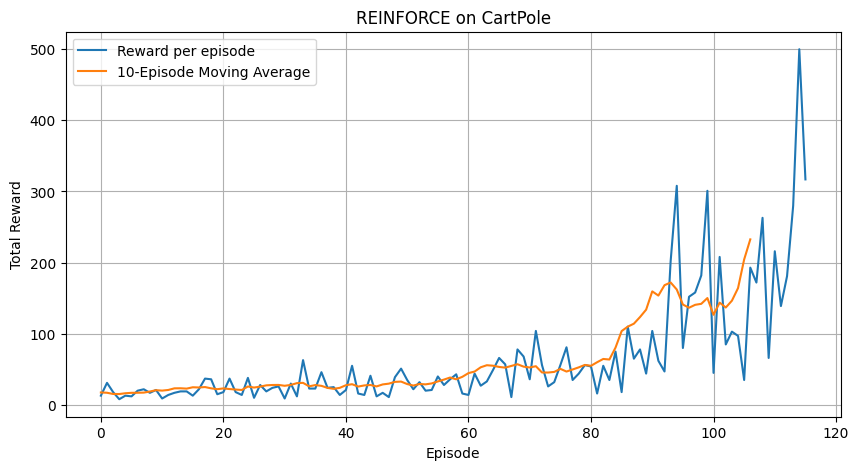

In [ ]:
import gym
import numpy as np
from collections import deque
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt
np.bool8 = np.bool_

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = gym.make('CartPole-v1')

class Policy(nn.Module):
  def __init__(self, state_size=4, action_size=2, hidden_size=32):
    super(Policy, self).__init__()
    self.fc1 = nn.Linear(state_size, hidden_size)
    self.fc2 = nn.Linear(hidden_size, action_size)

  def forward(self, state):
    x = F.relu(self.fc1(state))
    x = self.fc2(x)
    return F.softmax(x, dim=1)

  def act(self, state):
    state = torch.from_numpy(state).float().unsqueeze(0).to(device)
    probs = self.forward(state).cpu()
    model = Categorical(probs)
    action = model.sample()
    return action.item(), model.log_prob(action)

def REINFORCE(policy, episodes=500, max_t=1000, learning_rate=1e-2, gamma=0.99):

  scores = []
  optimizer = optim.Adam(policy.parameters(), lr=learning_rate)

  for episode in range(episodes):
    saved_log_probs = []
    rewards = []
    state = env.reset()

    # Trajectory collection
    for t in range(max_t):
      action, log_prob = policy.act(state)
      saved_log_probs.append(log_prob)
      state, reward, done, _ = env.step(action)
      rewards.append(reward)
      if done:
        break

    scores.append(sum(rewards))

    # Discounted returns calculation
    discounted_returns = []
    R = 0
    for r in reversed(rewards):
      R = r + gamma * R
      discounted_returns.insert(0, R)

    # Discounted returns normalization
    discounted_returns = torch.tensor(discounted_returns)
    discounted_returns = (discounted_returns - discounted_returns.mean()) / (discounted_returns.std() + 1e-5)

    # Loss calculation
    policy_loss = []
    for log_prob, R in zip(saved_log_probs, discounted_returns):
      policy_loss.append(-log_prob * R)
    policy_loss = torch.cat(policy_loss).sum()

    # Policy update
    optimizer.zero_grad()
    policy_loss.backward()
    optimizer.step()

    if (episode+1) % 10 == 0:
      print(f'Episode: {episode-8}-{episode+1}, Average reward: {np.mean(scores[-11:-1]):.2f}')

    # Threshold: over 200 in recent 10 episodes
    if np.mean(scores[-11:-1]) > 200:
      print(f'Problem solved in {episode+1} episodes! Final reward:{scores[-1]:.0f}')
      break

  plt.figure(figsize=(10, 5))
  plt.plot(scores, label='Reward per episode')
  plt.plot(np.convolve(scores, np.ones(10)/10, mode='valid'), label='10-Episode Moving Average')
  plt.xlabel('Episode')
  plt.ylabel('Total Reward')
  plt.title('REINFORCE on CartPole')
  plt.legend()
  plt.grid(True)
  plt.show()

  return scores

policy = Policy().to(device)
scores = REINFORCE(policy)


As shown above, I utilized the REINFORCE algorithm to solve the CartPole environment.
The key part of the code is the REINFORCE function, where we sample a trajectory in each episode, take action, get reward and next state, calculate gradient, and then update the policy.
And class Policy is the neural network to learn a policy that maximizes the expected reward.
Without much hyperparameters tuning, the code is able to achieve a satisfying final reward (300+).
And I did not even have to use GPU for training.
This shows the great power of REINFORCE and its advantage over other function approximation algorithms we covered in the last lectures.